In [1]:
from functools import lru_cache
from sklearn.svm import SVC
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedKFold
sns.set()

from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import DBSCAN


In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion

# Introducción

https://scikit-learn.org/dev/modules/svm.html

* Algoritmo iterativo.
* Debido a cómo está matemáticamente planteado, el algoritmo converge y no hay óptimos locales. 
    * Podemos decir que llegar a la mejor solucion existente.
* Hay dos parámetros de stop en este algoritmo iterativo:
    * cantidad de iteraciones 
    * delta de mejora entre iteraciones 
* _Hiperparametro **C**_: podemos dejar de tener una linea que divida perfectamente a los puntos, y lograr obtener a un hiperplano que me divida bastante bien, no perfecto, y que pueda safar en un punto de ruido. Entonces el C nos permite jugar un poco. Permitimos porcentaje pequeño de ruido en la solución de éste problema.
* _Kernels_: nos ayuda a cambiar el producto itnerno. Simula estar en una dimension mas alta y lograr encontrar con un hiperplano y ahorrarnos costo computacional con el mismo kernel.
    * Es decir, solo cambiando el producto interno engañamos para multiplicar altas dimensiones.
    * Kernels más comunes:
        * Lineal: $K(a,b)=a.b+r$
            * con $r$ hiperparametro elegible.  
        * Polinomial: $K(a,b)=(a.b+r)^{d}$ 
            * con $r$ y $d$ hiperparametros elegibles.
            * con $d=1$ sería un kernel lineal.
        * Radial Kernel: RBF (Radial Base Function): $K(a,b)=e^{-\alpha(a-b)^{2}}$
            * con $\alpha$ hiperparametro elegible. 
        * Sigmoid: $K(a,b)=tanh(\alpha.a.b+c)$
            * con $\alpha$ y $c$ hiperparametros elegibles. 



    

# Kernels a utilizar

Teniendo en cuenta la biblografia de SVM:
https://scikit-learn.org/stable/modules/svm.html#complexity

El algoritmo puede llegar a ser $O(n_{features} \times n_{samples}^2)$ como $O(n_{features} \times n_{samples}^3)$
$O(n_{features} \times n_{samples}^3)$ lo cual para nuestro dataset a entrenar con casi 30k de instancias puede ser un gran problema. La alta dimensionalidad nos juega una gran pasada.

Aunque según la misma biblografia compartida, nos aclara que el caso lineal de SVM (LinearSVC) es muchisimo mas eficiente y puede escalar con millones de datos más.

Al inicio de este notebook se verá reflejado el trabajo realizado con el LinearSVC y habiendo realizado las predicciones de holdout con LinearSVC pero al final del notebooks mostraremos el trabajo realizado con kernels no linieales y demostrar que la alta dimensionalidad nos juega en contra. 



# Funciones que irán en el preprocessing.py

In [3]:
def get_dataframe_scaled(df, scaler_r):
    scaled = scaler_r.fit_transform(df)
    return pd.DataFrame(scaled, index = df.index, columns = df.columns)

from sklearn.feature_selection import VarianceThreshold

def filter_by_variance(df, threshold):
    cols_con_varianza = df.var().index.values
    _df = df[cols_con_varianza].copy()
    selector = VarianceThreshold(threshold=threshold)
    vt = selector.fit(_df)
    _df = _df.loc[:, vt.get_support()]
    return _df

def get_dataframe_polynomial(df, grade_r, interaction_only_r):
    poly = PolynomialFeatures(grade_r, interaction_only = interaction_only_r)
    return pd.DataFrame(poly.fit_transform(df))  

def expansion_numerica_reducida(X_df, componentes_finales = 68):
    scaled = MinMaxScaler().fit_transform(X_df)
    print('MinMaxScaler aplicado...')
    X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)
    svd = TruncatedSVD(n_components=23, n_iter=7, random_state=10)
    X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))
    print('1° TruncatedSVD con 23 componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico_scaled_svd, 2, False)
    X_df_numerico_poly = filter_by_variance(X_df_numerico_poly, 0)
    print('PolynomialFeatures grado 2 aplicado se obtienen', len(X_df_numerico_poly.columns), 'nuevas componentes...')
    svd = TruncatedSVD(n_components=componentes_finales, n_iter=7, random_state=10)
    X_df_expandido = pd.DataFrame(svd.fit_transform(X_df_numerico_poly))
    print('2° TruncatedSVD con',  componentes_finales, 'componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    return X_df_expandido

def reduccion_numerica(X_df, componentes_finales = 23):
    scaled = MinMaxScaler().fit_transform(X_df)
    X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)

    svd = TruncatedSVD(n_components=componentes_finales, n_iter=7, random_state=10)
    X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))
    print('TruncatedSVD con',  componentes_finales, 'componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    return X_df_numerico_scaled_svd

# LinearSVC

In [4]:
from sklearn.svm import LinearSVC

Segun la biblografía de LinearSVC, el mismo es como usar a SVC(kernel='linear') pero que está implementado con la libreria de **liblinear** en vez de **libsvm**. Esto nos permite ser mas flexibles en las seleccion mediante una funcion de perdida y en la penalización de los datos. Es decir, tendremos 2 nuevos hiperparametros a probar:

**(despues describir mejor estos hiperparametros)**
* Penalty
    * l1
    * l2
* Loss:
    * hinge
    * squared_hinge



## Primer preprocesamiento: conversion_numerica() + MinMaxScaler()

Además de la **conversion_numerica()** también aplicaremos un escalado de los datos que es recomendado según la biblografía (https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use).

In [5]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.3min finished


[LibLinear]Accuracy sobre test:  0.8455396898510671
Los mejores hiperpametros elegidos:  {'C': 72, 'loss': 'squared_hinge', 'penalty': 'l2'}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.87      0.90      5345
  Alto valor       0.55      0.74      0.63      1168

    accuracy                           0.85      6513
   macro avg       0.75      0.80      0.77      6513
weighted avg       0.87      0.85      0.85      6513



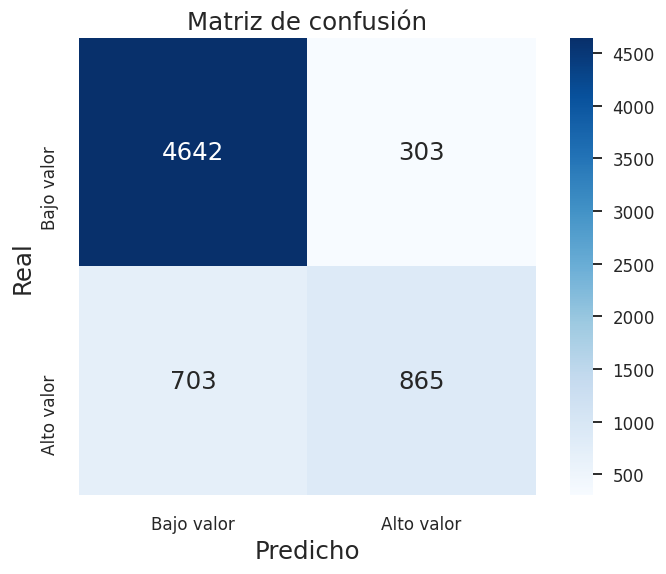

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [ {'C':np.arange(0,100,2), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)


Para conseguir la metrica AUC-ROC, sobre LinearSVC() no es posible

In [7]:
# clf.predict_proba(X_test)[:, 1]

Cuando se entrena con el SVC() tampoco es posible a no ser que se le especifique el parametro 'probability=True'.

Segun la biblografía: https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities
        
        Note: The same probability calibration procedure is available for all estimators via the CalibratedClassifierCV. In the case of SVC and NuSVC, this procedure is builtin in libsvm which is used under the hood, so it does not rely on scikit-learn’s CalibratedClassifierCV.

Por ende utilizaremos 'CalibratedClassifierCV' para predecir la probabilidad de las clases y graficar el AUC-ROC score.
        

AUC-ROC score sobre test:  0.8958856735312930


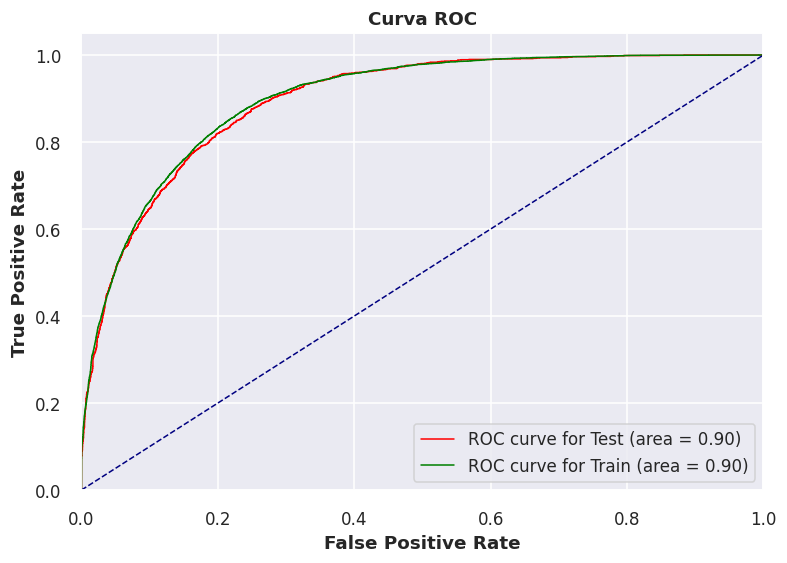

In [8]:
from sklearn.calibration import CalibratedClassifierCV

clf_best=LinearSVC(random_state=10, dual=False, C = 72, loss= 'squared_hinge', penalty='l2')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

## Segundo preprocesamiento: expansion_numerica_reducida()

In [9]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_df_expandido = expansion_numerica_reducida(X_df_numerico, 25)

MinMaxScaler aplicado...
1° TruncatedSVD con 23 componentes finales se explica una varianza de: 0.9536277314
PolynomialFeatures grado 2 aplicado se obtienen 299 nuevas componentes...
2° TruncatedSVD con 25 componentes finales se explica una varianza de: 0.8495850213


In [10]:
X_df_expandido.shape

(32561, 25)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


[LibLinear]Accuracy sobre test:  0.8277291570704745
Los mejores hiperpametros elegidos:  {'C': 8, 'loss': 'squared_hinge', 'penalty': 'l1'}
              precision    recall  f1-score   support

  Bajo valor       0.92      0.86      0.89      5317
  Alto valor       0.52      0.69      0.59      1196

    accuracy                           0.83      6513
   macro avg       0.72      0.77      0.74      6513
weighted avg       0.85      0.83      0.84      6513



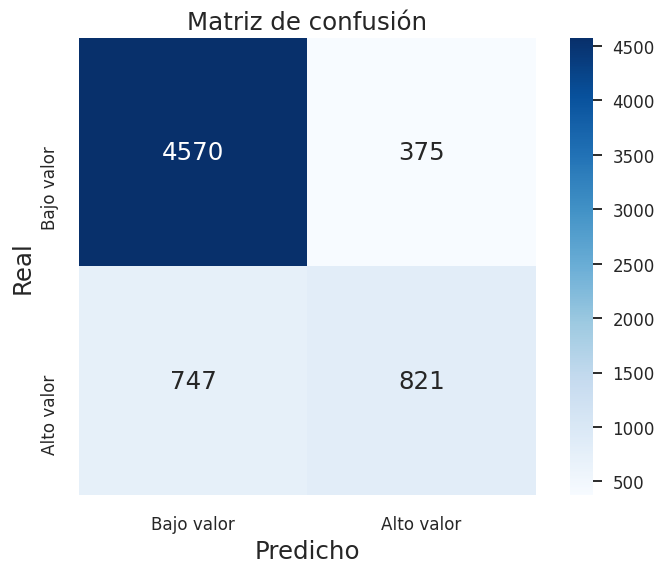

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_df_expandido, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [ {'C':np.arange(0,100,2), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)


AUC-ROC score sobre test:  0.8777115231835910


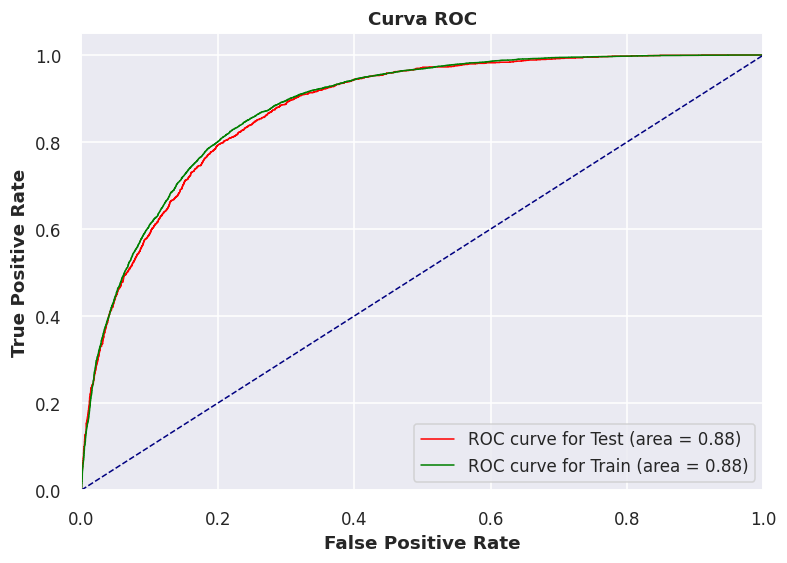

In [12]:
from sklearn.calibration import CalibratedClassifierCV

clf_best=LinearSVC(random_state=10, dual=False, C = 8, loss = 'squared_hinge', penalty ='l1')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

# SVC con distintos Kernels

## Primer preprocessamiento: reduccion_numerica()

Debido a tiempo computacional, limitaremos a 'max_iter' con 100. Si no hacemos esto, el algoritmo tardaria un monton en procesar. 

Aca es donde se nota la ineficiencia de SVC con distintos con la big data.

Además aplicaremos una reducción de dimensionalidad bastante profunda, conservando un ~85% de la varianza.

En el notebook de ***tp_FIUFIP_parte1_extras.ipynb*** habiamos conseguido mantener un 95% de la varianza aplicando un preprocesamietno de MinMaxScaler+TruncatedSVD con 22 componentes. Además graficámos con t-SNE con 2 componentes y logramos visualizar una buena reducción de los datos.

Ahora lo haremos simplemente con 15, manteniendo un 85%. Todo para tratar de reducir tiempo de computo.

In [13]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_df_numerico = reduccion_numerica(X_df_numerico, 15) 
X_df_numerico.shape

TruncatedSVD con 15 componentes finales se explica una varianza de: 0.8451601963


(32561, 15)

Además volvemos a aplicar otro escalado de los datos en el Split realizado, en *X_train* y *X_test* tal como nos recomienda la biblografía (https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use).


Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.3min finished


[LibSVM]

/home/feduntu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


AUC-ROC score sobre test:  0.8027665932399248
Accuracy sobre test:  0.7750652541071703
Los mejores hiperpametros elegidos:  {'C': 500, 'degree': 2, 'gamma': 0.05, 'kernel': 'poly'}
              precision    recall  f1-score   support

  Bajo valor       0.84      0.86      0.85      4842
  Alto valor       0.57      0.53      0.55      1671

    accuracy                           0.78      6513
   macro avg       0.70      0.70      0.70      6513
weighted avg       0.77      0.78      0.77      6513



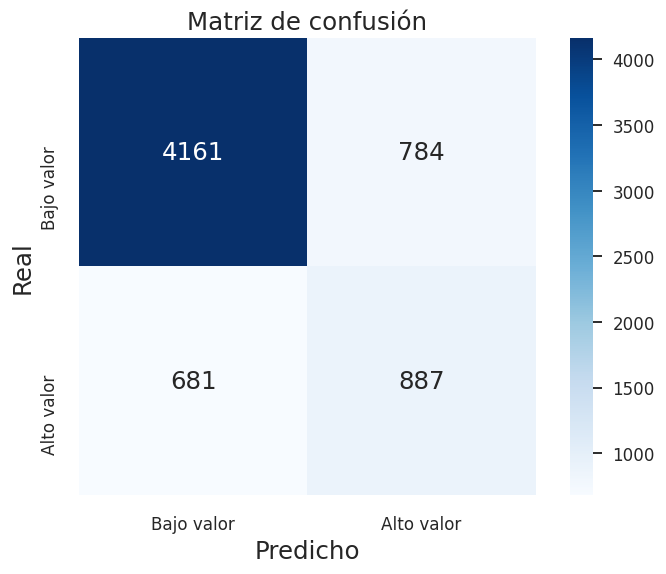

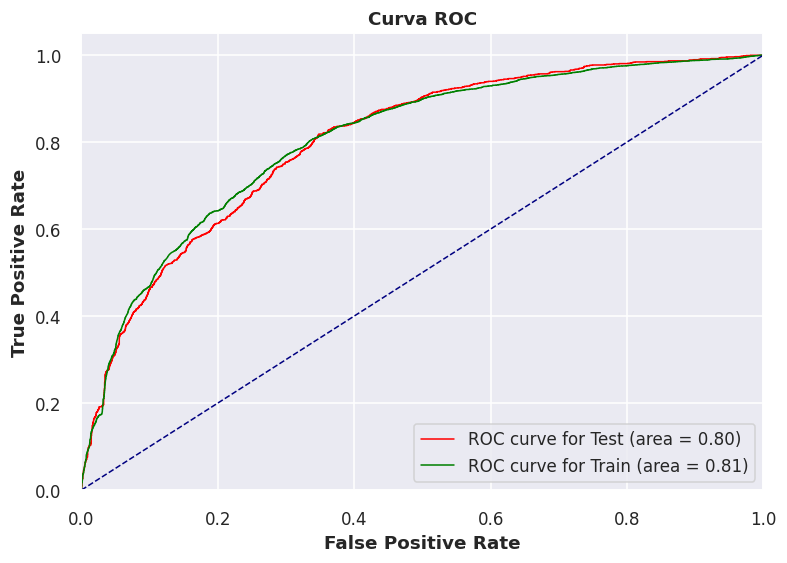

In [14]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [{'C':[1, 100, 300, 500, 700, 1000], 'kernel':['linear']},
          {'C':[1, 100, 300, 500, 700, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.3, 0.5, 0.7, 0.9]},
          {'C':[1, 100, 300, 500, 700, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.03,0.05, 0.07,0.09]}]

clf=SVC(probability = True, random_state=10,verbose=True, cache_size = 5000, max_iter=100)

cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf.predict_proba(X_test)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)

## Segundo preprocesamiento: expansion_numerica_reducida()

In [15]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_df_expandido = expansion_numerica_reducida(X_df_numerico, 25)

MinMaxScaler aplicado...
1° TruncatedSVD con 23 componentes finales se explica una varianza de: 0.9536277314
PolynomialFeatures grado 2 aplicado se obtienen 299 nuevas componentes...
2° TruncatedSVD con 25 componentes finales se explica una varianza de: 0.8495850213


Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed: 11.1min finished


[LibSVM]

/home/feduntu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


AUC-ROC score sobre test:  0.8407017369637440
Accuracy sobre test:  0.7403654230001535
Los mejores hiperpametros elegidos:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

  Bajo valor       0.73      0.91      0.81      3936
  Alto valor       0.78      0.48      0.59      2577

    accuracy                           0.74      6513
   macro avg       0.75      0.69      0.70      6513
weighted avg       0.75      0.74      0.72      6513



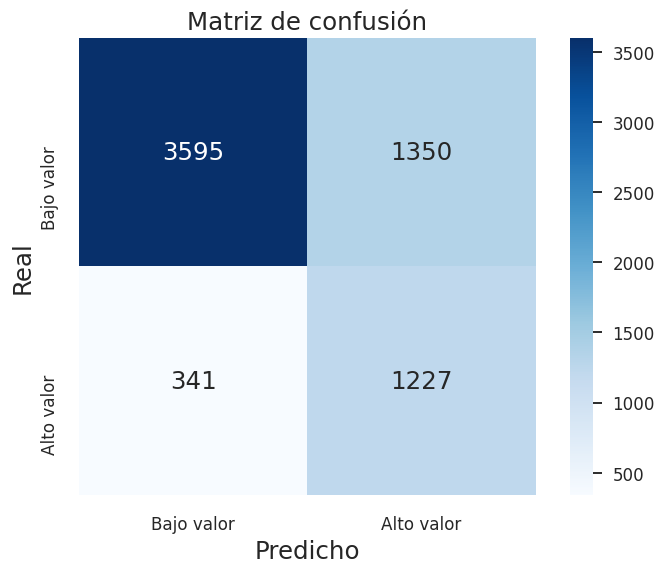

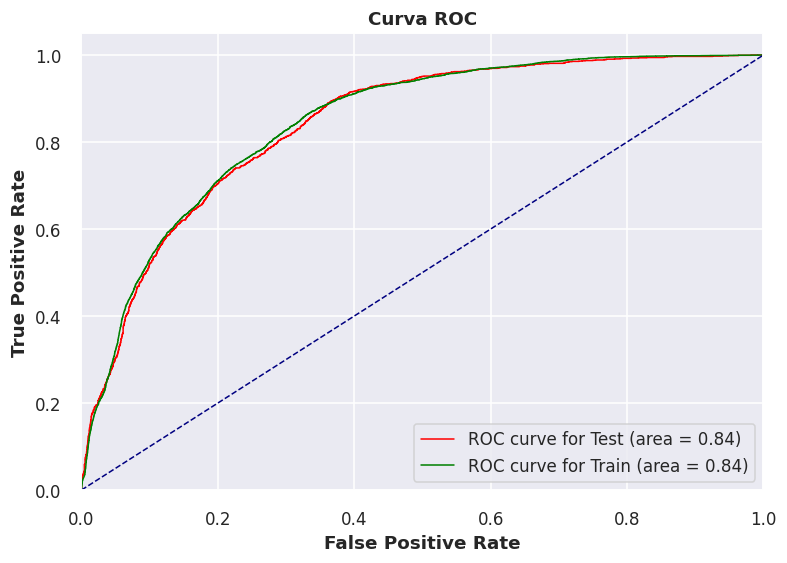

In [16]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X_df_expandido, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [{'C':[1, 100, 300, 500, 1000], 'kernel':['linear']},
          {'C':[1, 100, 300, 500, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.3, 0.5, 0.7, 0.9]},
          {'C':[1, 100, 300, 500, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.03,0.05, 0.07,0.09]}]

clf=SVC(probability = True, random_state=10,verbose=True, cache_size = 5000, max_iter=150)

cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf.predict_proba(X_test)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)